# Classificare il rischio di mortalità di pazienti con il COVID-19

**Programmazione di Applicazioni Data Intensive - 2022/2023**  
Laurea in Ingegneria e Scienze Informatiche - Università di Bologna, Cesena

<p>Pablo Sebastian Vargas Grateron - Mat: 0000970487</p>
<p>Sara Romeo - Mat: 0000969946</p>

## Obiettivo del progetto

L'obiettivo del progetto è analizzare diversi modelli di classificazione per poter prevedere la probabilità maggiore che una persona sopravviva al COVID-19, basandosi sulle altre malattie con cui il soggetto convive. Il maggior rischio di probabilità viene calcolato in base a casi precedenti di pazienti con condizioni simili che hanno a loro volta riscontrato il COVID-19.

## Import delle librerie

In [69]:
# Librerie standard
import os.path
from zipfile import ZipFile
import copy
import time

# Librerie esterne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Caricamento dei dati 

Variabili utilizzate per il caricamento semplificato di dati.

In [70]:
zip_name = "archive.zip"
zip_link = "https://www.kaggle.com/datasets/meirnizri/covid19-dataset"
csv_name = "Covid Data.csv"

In [71]:
if not os.path.exists(zip_name):
    print("Error: Dataset not found, download id from " + zip_link)
else:
    with ZipFile(zip_name) as f:
        f.extractall()

In [72]:
with open(csv_name) as dataFile:
    data_raw = pd.read_csv(dataFile, sep=",")

Controlliamo le prime e ultime 5 righe con le apposite funzioni di pandas `head()` e `tail()`.

In [73]:
data_raw.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [74]:
data_raw.tail()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97
1048574,2,13,2,1,9999-99-99,97,2,52,97,2,...,2,2,2,2,2,2,2,2,7,97


### Descrizione delle colonne

1. `USMER`: se il paziente ha trattato unità sanitarie di primo, secondo o terzo livello.
2. `MEDICAL_UNIT`: tipologia di istituzione del Sistema Sanitario Nazionale che ha erogato le cure.
3. `SEX`: se il paziente è femmina 1, se maschio 2.
4. `PATIENT_TYPE`: tipo di cura che il paziente ha ricevuto nel reparto. 1 per dimesso e 2 per ricovero.
5. `DATE_DIED`: se il paziente è morto è indicata la data di morte, altrimenti 9999-99-99.
6. `INTUBED`: se il paziente era collegato alla ventilazione.
7. `PNEUMONIA`: se il paziente ha già un'infiammazione delle sacche aeree o meno.
8. `AGE`: età del paziente.
9. `PREGNANCY`: se la paziente è incinta o meno.
10. `DIABETES`: se il paziente ha o meno il diabete.
11. `COPD`: se il paziente è affetto o meno da broncopneumopatia cronica ostruttiva.
12. `ASTHMA`: se il paziente ha o meno l'asma.
13. `INMSUPR`: se il paziente è immunodepresso o meno.
14. `HYPERTENSION`: se il paziente soffre o meno di ipertensione.
15. `OTHER_DISEASE`: se il paziente ha altre malattie o meno.
16. `CARDIOVASCULAR`: se il paziente ha una malattia correlata al cuore o ai vasi sanguigni.
17. `OBESITY`: se il paziente è obeso o meno.
18. `RENAL_CHRONIC`: se il paziente ha o meno una malattia renale cronica.
19. `TOBACCO`: se il paziente è un consumatore di tabacco.
20. `CLASSIFICATION_FINAL`: risultati del test covid. I valori 1-3 indicano che al paziente è stato diagnosticato il covid in diversi gradi. 4 o superiore significa che il paziente non è portatore di covid o che il test non è conclusivo.
21. `ICU`: se il paziente è stato ricoverato in un'Unità di Terapia Intensiva.

## Analisi esplorativa e data cleaning

### Data cleaning

Prima di procedere con l'analisi dei dati, effettuiamo qualche operazione di data cleaning. Per prima cosa controlliamo i tipi di dati con il quale è strutturato il dataset: così facendo potremo correggere eventuali assegnazioni incorrette.

In [75]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

Procediamo a cambiare il tipo di dato della colonna `DATE_DIED` da `object` a `datetime64`. Prima di cambiare il formato della data, modifichiamo le date che contengano esattamente il valore 9999-99-99, che rappresentano i pazienti che non sono morti.

In [76]:
data_raw.replace("9999-99-99", np.nan, inplace=True)
data_raw["DATE_DIED"] =  pd.to_datetime(data_raw["DATE_DIED"], format="%d/%m/%Y")

Il dataset fornito inizialmente contiene valori nulli che sono stati definiti usando numeri che vanno da  `97` a `99`.
Definiamo quindi `null` tutti i valori nel range, evitando di modificare la colonna `AGE`.

In [77]:
temp_data = copy.deepcopy(data_raw)
temp_data.drop("AGE", axis=1, inplace=True)
temp_data.replace(97, np.nan, inplace=True)
temp_data.replace(98, np.nan, inplace=True)
temp_data.replace(99, np.nan, inplace=True)
temp_data["AGE"] = data_raw["AGE"]

Avendo copiato il dataset in una variabile temporanea (`temp_data`), per comodità riordiniamo le colonne nella stessa sequenza in cui si trovavano inizialmente.
Infine memoriziamo il dataset pulito dentro una nuova variabile chiamata `data_clean`.

In [78]:
temp_data = temp_data.reindex(columns=["USMER", "MEDICAL_UNIT", "SEX", "PATIENT_TYPE", "DATE_DIED", "INTUBED", "PNEUMONIA", "AGE", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO", "CLASIFFICATION_FINAL", "ICU"])
data_clean = temp_data

In [79]:
data_clean.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,2020-05-03,NaN,1.0,65,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN
1,2,1,2,1,2020-06-03,NaN,1.0,72,NaN,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5,NaN
2,2,1,2,2,2020-06-09,1.0,2.0,55,NaN,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
3,2,1,1,1,2020-06-12,NaN,2.0,53,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
4,2,1,2,1,2020-06-21,NaN,2.0,68,NaN,1.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN


In [80]:
data_clean.tail()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
1048570,2,13,2,1,NaT,NaN,2.0,40,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
1048571,1,13,2,2,NaT,2.0,2.0,51,NaN,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,7,2.0
1048572,2,13,2,1,NaT,NaN,2.0,55,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
1048573,2,13,2,1,NaT,NaN,2.0,28,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
1048574,2,13,2,1,NaT,NaN,2.0,52,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN


### Gestione dei dati nulli

Adesso che il dataset è correttamente impostato, controlliamo se ci sono valori nulli. Si puo osservare che particolarmente le colonne `DATA_DIED`, `INTUBED`, `PREGNANT` e `ICU` hanno un numero significativo di valori mancanti. `DATA_DIED` presenta valori nulli per via del fatto che certe persone non sono morte, mentre `PREGNANT` a causa della presenza di pazienti di sesso maschile.

In [81]:
data_clean.isnull().sum()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED               971633
INTUBED                 855869
PNEUMONIA                16003
AGE                          0
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64

Procediamo a cambiare i valori `NaN` presenti nella colonna `PREGNANT` per ogni maschio con il valore `2` (Equivalente a `False`).

In [82]:
data_clean["PREGNANT"] = np.where((data_clean['SEX'] == 2) & (data_clean['PREGNANT'].isnull()), 2, data_clean['PREGNANT'])

Eliminiamo anche le colonne `INTUBED` e `ICU` perché ci sono troppi valori `NaN`, e fare uso di qualche metodo per completare queste colonne potrebbe compromettere la precisione del modello.

In [83]:
data_clean.drop("INTUBED", axis=1, inplace=True)
data_clean.drop("ICU", axis=1, inplace=True)

Adesso che le colonne con valori `NaN` in quantità più significativa (considerando la dimensione del dataset di 1.048.575 righe) sono state rimosse procediamo a eliminare i valori nulli delle altre colonne.

In [84]:
data_clean.dropna(subset=['PREGNANT', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO'], inplace=True)

Per lo sviluppo del modello ci interessa capire se i pazienti sono morti o ancora vivi. Per questo, si utilizza la colonna `DATE_DIED` per definire una nuova colonna booleana `DECEASED` e procediamo a eliminare la colonna `DATE_DIED` dato che la dimensione temporale non è utile per questo progetto.

In [85]:
data_clean['DECEASED'] = np.where(data_clean['DATE_DIED'].isnull(), 2, 1)
data_clean.drop("DATE_DIED", axis=1, inplace=True)

Per analizzare i casi di Covid-19, utilizziamo la colonna `CLASSIFICATION_FINAL`, la quale ha numeri in un range da 1 a 7, dove i numeri da 1 a 3 rappresentano i casi positivi per generarne una nuova chiamata `RESULT` la quale conterra `1` se il paziente è positivo, `0` altrimenti. Al termine dell'operazione eliminiamo `CLASSIFICATION_FINAL`.

In [86]:
data_clean["RESULT"] = np.where(data_clean['CLASIFFICATION_FINAL'] < 4, 1, 2)
data_clean.drop("CLASIFFICATION_FINAL", axis=1, inplace=True)

Adesso che tutti i valori del dataset sono stati gestiti, controlliamo nuovamente i valori `null` del dataset e poi usiamo la funzione `describe()` per ottenere ulteriori dati riguardanti il dataset e le sue feature.

In [87]:
data_clean.isnull().sum()

USMER             0
MEDICAL_UNIT      0
SEX               0
PATIENT_TYPE      0
PNEUMONIA         0
AGE               0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
DECEASED          0
RESULT            0
dtype: int64

In [88]:
data_clean.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DECEASED,RESULT
count,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06,1.021977e+06
mean,1.642009e+00,8.987361e+00,1.500927e+00,1.187472e+00,1.865591e+00,4.189535e+01,1.992328e+00,1.880455e+00,1.985951e+00,1.970238e+00,1.986734e+00,1.844163e+00,1.973498e+00,1.980346e+00,1.846773e+00,1.982074e+00,1.919237e+00,1.926948e+00,1.620739e+00
std,4.794098e-01,3.724244e+00,4.999994e-01,3.902901e-01,3.410915e-01,1.674953e+01,8.725552e-02,3.244286e-01,1.176940e-01,1.699299e-01,1.144135e-01,3.627011e-01,1.606215e-01,1.388085e-01,3.602059e-01,1.326828e-01,2.724710e-01,2.602212e-01,4.852034e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00
50%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,2.000000e+00,4.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,2.000000e+00,5.300000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,2.000000e+00,1.210000e+02,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


### Analisi esplorativa

#### Distribuzione delle strutture, attenzione medica e casi registrati di Covid-19

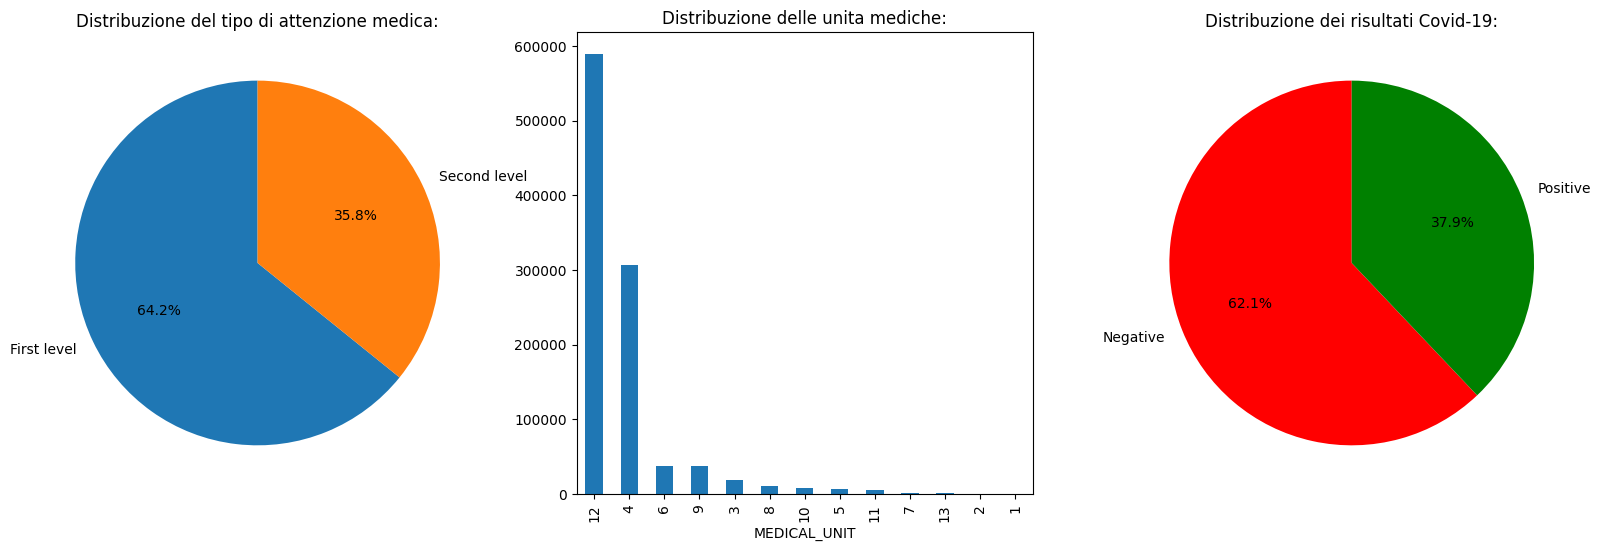

In [112]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1).pie(data_clean["USMER"].value_counts(), labels = ["First level", "Second level"], startangle=90, autopct='%1.1f%%')
plt.title('Distribuzione del tipo di attenzione medica:');

data_clean["MEDICAL_UNIT"].value_counts().plot.bar(ax=plt.subplot(1, 3, 2))
plt.title('Distribuzione delle unita mediche:');

plt.subplot(1, 3, 3).pie(data_clean["RESULT"].value_counts(), labels = ["Negative", "Positive"],  colors = data_clean["SEX"].map({1:"red", 2:"green"}), startangle=90, autopct='%1.1f%%')
plt.title('Distribuzione dei risultati Covid-19:');

Questa rappresentazione ci mostra il tipo di attenzione medica con il quale il paziente è stato trattato (`USMER`) e l'unità medica nella quale è stato trattato (`MEDICAL_UNIT`). Il primo grafico mostra come 1/3 dei pazienti ha ricevuto attenzione medica importante, mentre nell'istogramma si può osservare che l'unità medica 12 è quella che ha trattato gran parte dei pazienti, insieme all'unità 4.

Dall'ultimo grafico si evince come il tipo di attenzione medica sia leggermente correlato all'esito di positività per il Covid-19.

#### Distribuzione dell'eta dei pazienti, sesso e gravidanza

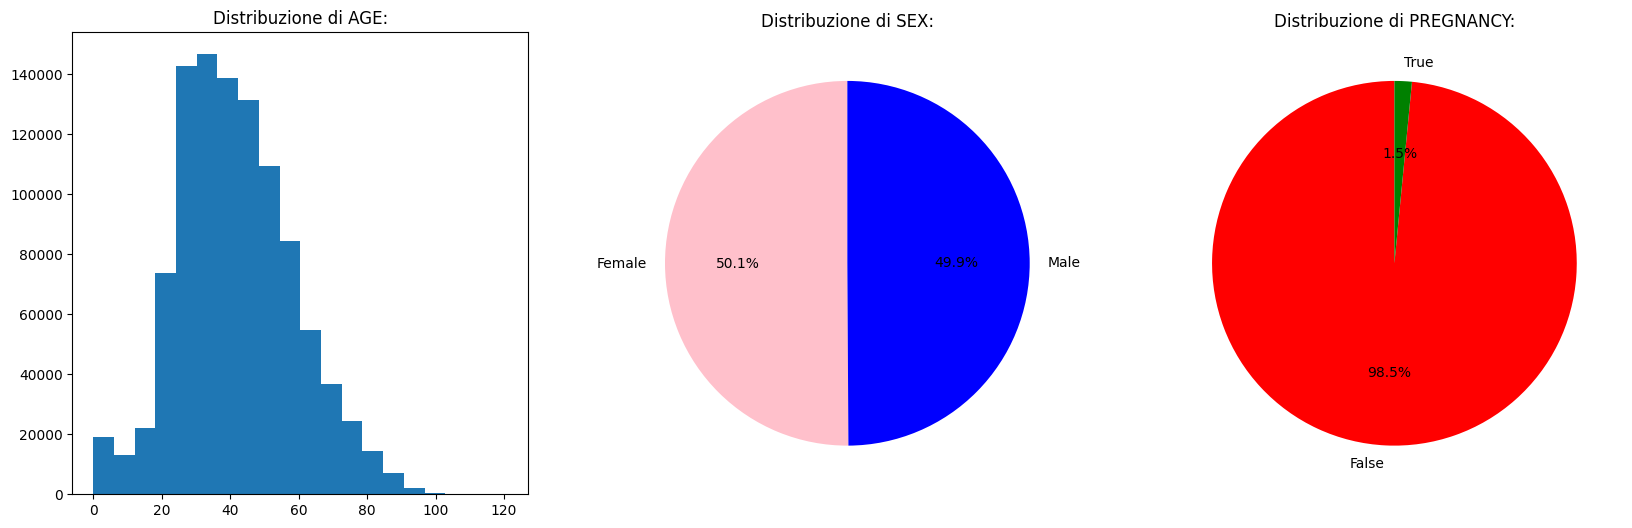

In [90]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1).hist(data_clean["AGE"], bins=20)
plt.title('Distribuzione di AGE:');

plt.subplot(1, 3, 2).pie(data_clean["SEX"].value_counts(), labels = ["Female", "Male"], colors = data_clean["SEX"].map({1:"pink", 2:"blue"}), startangle=90, autopct='%1.1f%%')
plt.title('Distribuzione di SEX:');

plt.subplot(1, 3, 3).pie(data_clean.loc[data_clean["SEX"] == 1]["PREGNANT"].value_counts(), labels = ["False", "True"], colors = data_clean["SEX"].map({1:"red", 2:"green"}), startangle=90, autopct='%1.1f%%')
plt.title('Distribuzione di PREGNANCY:');


In questi grafici possiamo osservare che il dataset contiene pazienti che in gran parte sono contenuti nel range di 20 e 60 anni d'età. Mentre la distribuzione del sesso è bilanciata, quella della gravidanza tra le donne è significativamente sbilanciata, infatti solo l'1,5% è incinta.

#### Distribuzione delle malattie, sintomi e complicazioni mediche

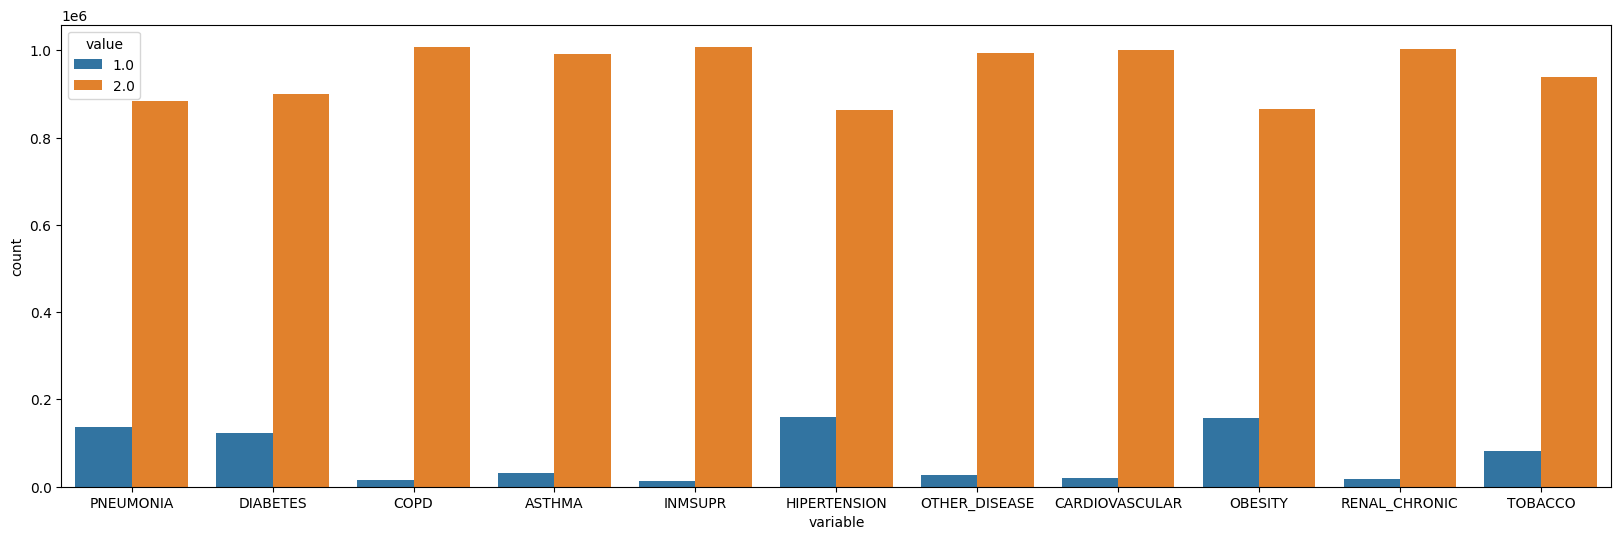

In [91]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 6

df_categorical = data_clean.loc[:, ['PNEUMONIA','DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']]
sns.countplot(x="variable", hue="value", data= pd.melt(df_categorical));

Grazie all'istorgramma sulla distribuzione delle malattie possiamo notare che per ogni malattia presa in considerazione ci sono meno di 200.000 pazienti. 

#### Distribuzione della variabile target

Osserviamo la distribuzione della feature obiettivo `DECEASED`, la quale ci permetterà di stabilire la classe predetta (alto o basso rischio di mortalità).

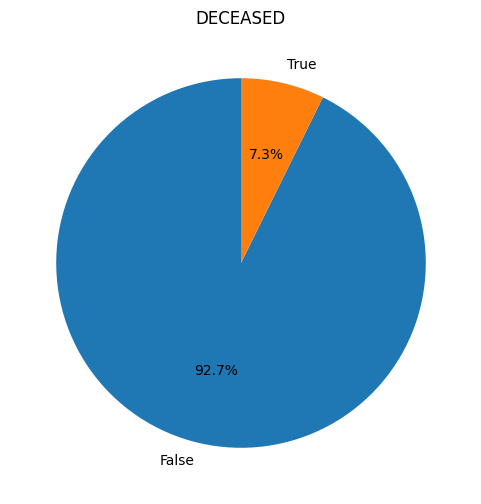

In [92]:
data_clean['DECEASED'].value_counts().plot.pie(labels = ["False", "True"], startangle=90, autopct='%1.1f%%', title="DECEASED", ylabel="");

Il dataset è signicativamente sbilanciato, con il 92.7% dei pazienti sopravvissuti. Questo comporterà l'utilizzo di tecniche di bilanciamento delle classi negli step successivi.

#### Relazione tra l'età, sesso e deceduti

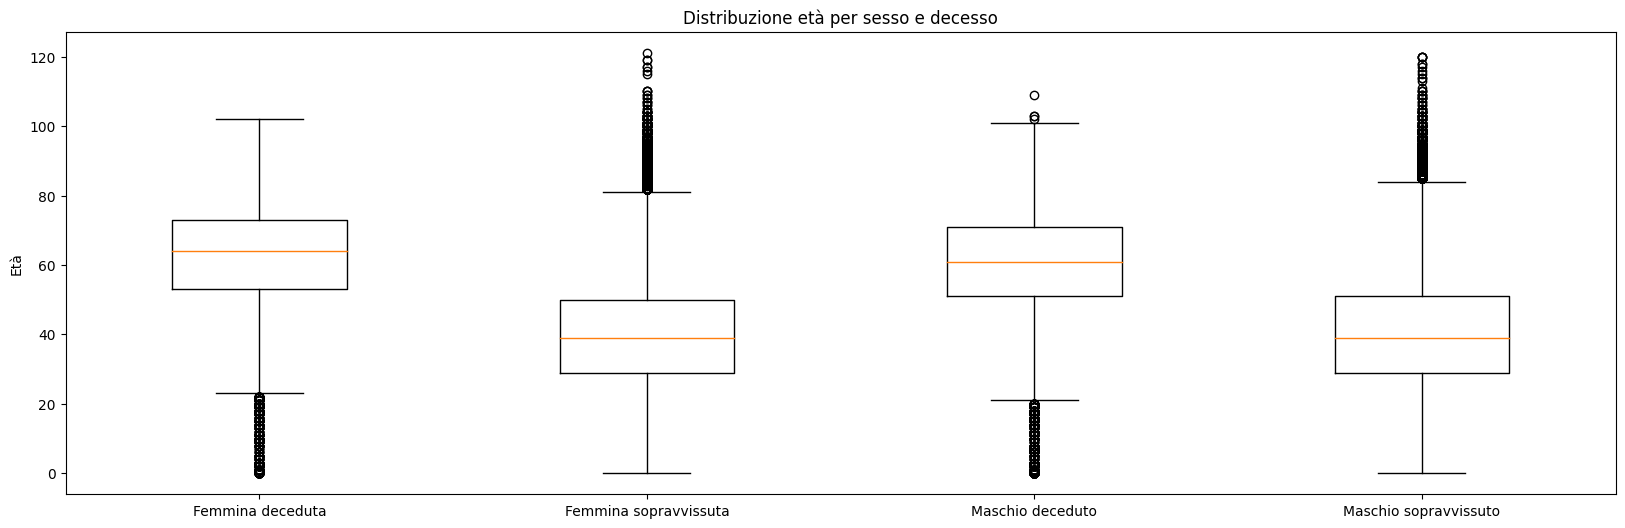

In [93]:
plt.figure(figsize=(20, 6))
plt.boxplot([data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["SEX"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["SEX"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["SEX"] == 2)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["SEX"] == 2)]['AGE']])
plt.title('Distribuzione età per sesso e decesso')
plt.xticks([1, 2, 3, 4], ['Femmina deceduta', 'Femmina sopravvissuta', 'Maschio deceduto', 'Maschio sopravvissuto'])
plt.ylabel('Età');

Si nota che la maggior parte di persone decedute sono comprese tra i 50 e 80 anni d'età, indipendentemente dal sesso.

Non controlliamo la relazione con le donne in gravidanza dato che non ce ne sono di decedute.

In [94]:
len(data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["SEX"] == 2) & (data_clean["PREGNANT"] == 1)])

0

#### Relazione tra le complicazioni polmonari, cardiopatie e deceduti

Dall'informazione estratta nel paper **Position paper ANMCO: Malattie del circolo polmonare e COVID-19** (https://www.giornaledicardiologia.it/archivio/3405/articoli/33888/), il rischio di morte dato dal Covid-19 può essere molto correlato con cardiopatie e malattie polmonari. Data l'importanza di questa informazione, vogliamo analizzare la relazione tra le colonne `PNEUMONIA`, `ASTHMA`, `HIPERTENSION` e `CARDIOVASCULAR`.

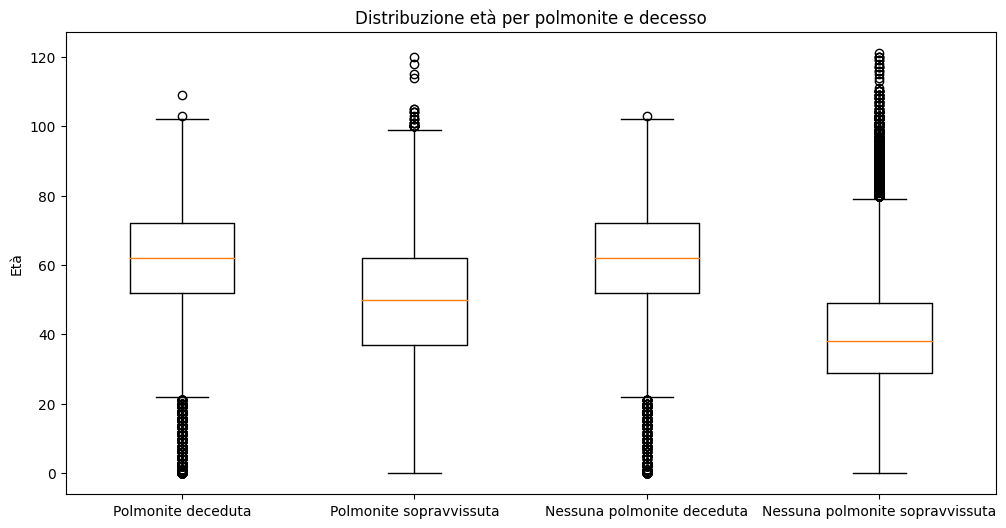

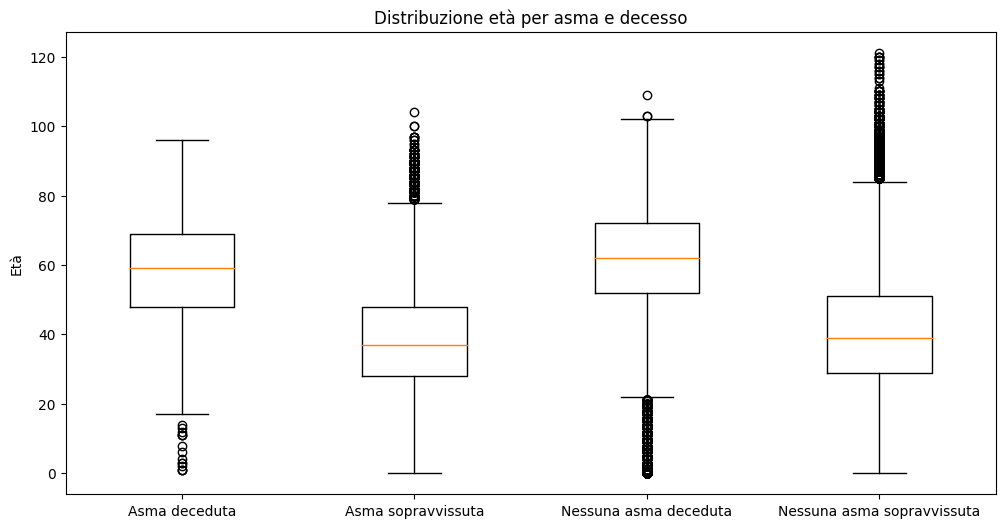

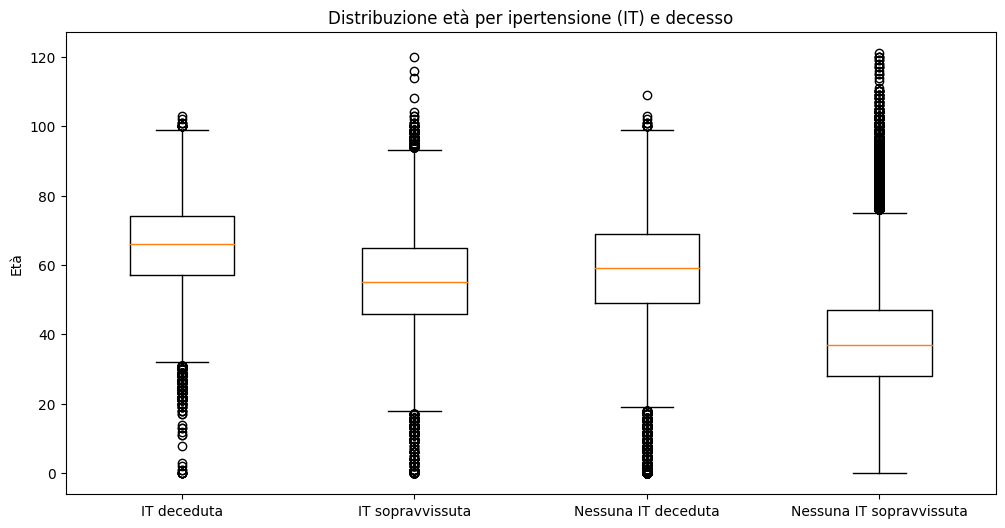

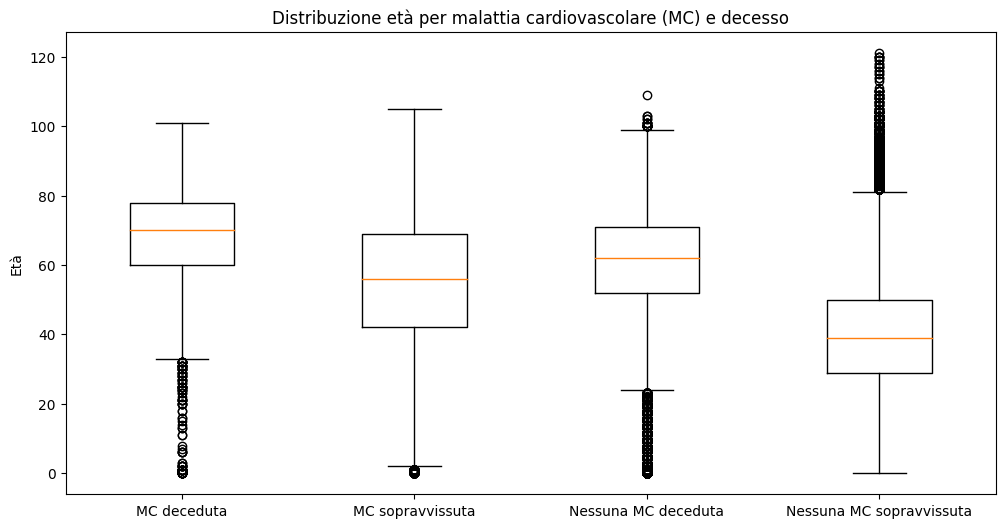

In [95]:
plt.figure(figsize=(12, 6))
plt.boxplot([data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["PNEUMONIA"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["PNEUMONIA"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["PNEUMONIA"] == 2)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["PNEUMONIA"] == 2)]['AGE']])
plt.title('Distribuzione età per polmonite e decesso')
plt.xticks([1, 2, 3, 4], ['Polmonite deceduta', 'Polmonite sopravvissuta', 'Nessuna polmonite deceduta', 'Nessuna polmonite sopravvissuta'])
plt.ylabel('Età');

plt.figure(figsize=(12, 6))
plt.boxplot([data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["ASTHMA"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["ASTHMA"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["ASTHMA"] == 2)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["ASTHMA"] == 2)]['AGE']])
plt.title('Distribuzione età per asma e decesso')
plt.xticks([1, 2, 3, 4], ['Asma deceduta', 'Asma sopravvissuta', 'Nessuna asma deceduta', 'Nessuna asma sopravvissuta'])
plt.ylabel('Età');

plt.figure(figsize=(12, 6))
plt.boxplot([data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["HIPERTENSION"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["HIPERTENSION"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["HIPERTENSION"] == 2)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["HIPERTENSION"] == 2)]['AGE']])
plt.title('Distribuzione età per ipertensione (IT) e decesso')
plt.xticks([1, 2, 3, 4], ['IT deceduta', 'IT sopravvissuta', 'Nessuna IT deceduta', 'Nessuna IT sopravvissuta'])
plt.ylabel('Età');

plt.figure(figsize=(12, 6))
plt.boxplot([data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["CARDIOVASCULAR"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["CARDIOVASCULAR"] == 1)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 1) & (data_clean["CARDIOVASCULAR"] == 2)]['AGE'],
            data_clean.loc[(data_clean["DECEASED"] == 2) & (data_clean["CARDIOVASCULAR"] == 2)]['AGE']])
plt.title('Distribuzione età per malattia cardiovascolare (MC) e decesso')
plt.xticks([1, 2, 3, 4], ['MC deceduta', 'MC sopravvissuta', 'Nessuna MC deceduta', 'Nessuna MC sopravvissuta'])
plt.ylabel('Età');

È interessante notare come le malattie respiratorie siano molto più correlate all'età rispetto alle malattie cardiovascolari.
Infatti chi soffre di `PNEUMONIA` e `ASTHMA` tende a sopravvivere se in età giovane, rispetto a chi soffre di `HIPERTENSION` e `CARDIOVASCULAR` che tra sopravvissuti e deceduti non permette di rilevare grosse differenze di età.

Inoltre dai grafici di `PNEUMONIA` e `CARDIOVASCULAR` risalta come lo spettro delle età dei sopravvissuti sia molto più ampio di quello per `ASTHMA` ed `HIPERTENSION`. Siccome il range è così grande possiamo assumere che mentre per i casi di decesso l'età sia strettamente correlata, per quanto riguarda la sopravvivenza non è così rilevante come parametro.

Quindi in questi casi di ampio range potremmo dire che l'anzianità non è sufficiente a stabilire che ci siano maggiori rischi di mortalità, mentre negli altri essere giovani è quasi direttamente riconducibile alla sopravvivenza del soggetto.

#### Correlazione tra tutte le features del dataset

Infine per avere una panoramica più precisa e completa, calcoliamo la correlazione tramite il coefficiente di Pearson tra tutte le features esistenti.

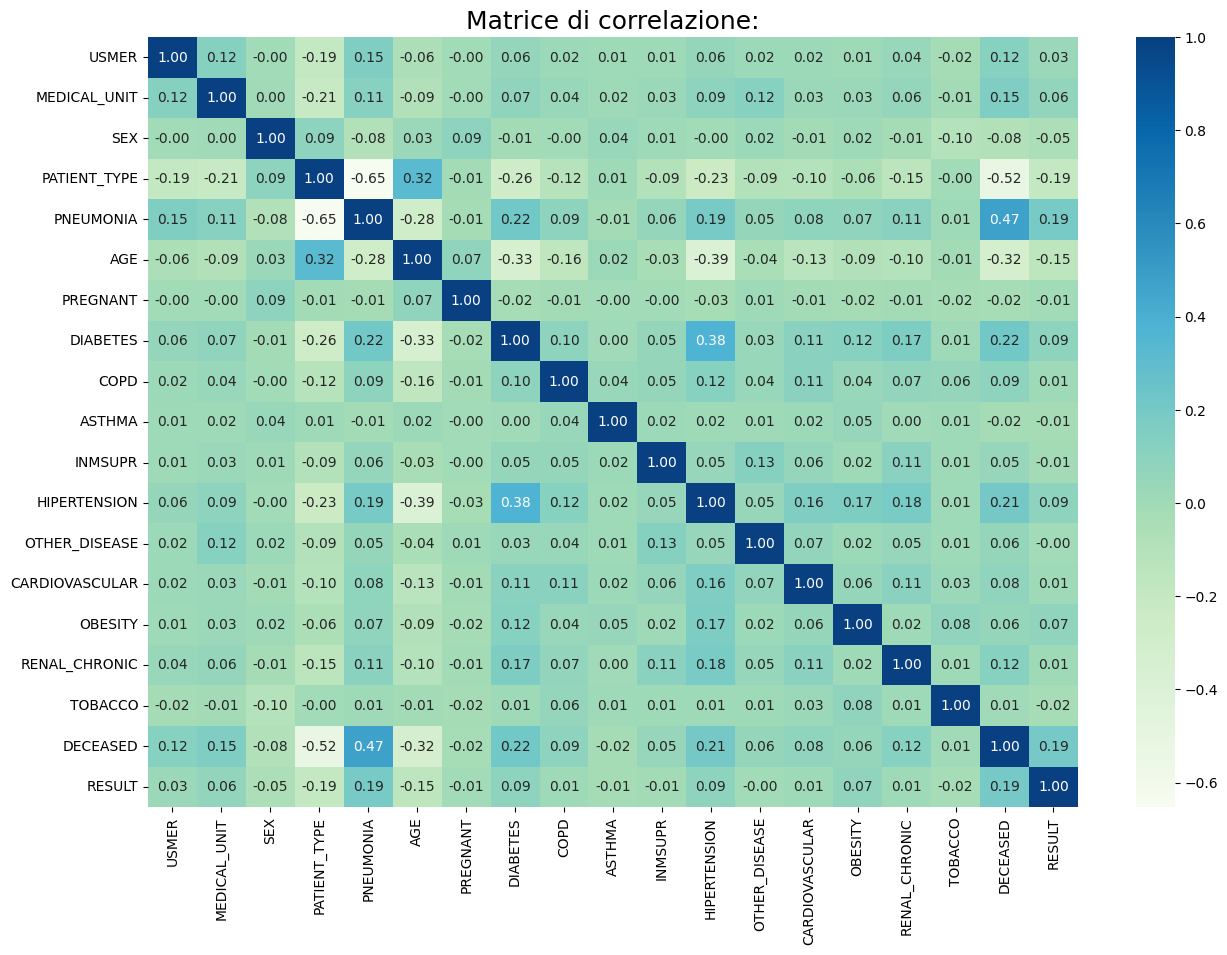

In [106]:
correlation_df = data_clean.corr(method="pearson")

plt.figure(figsize=(15,10))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="GnBu")
plt.title("Matrice di correlazione:", fontsize=18);

## Addestramento e analisi dei modelli

### Preparazione del dataset

Scartiamo i dati che hanno bassa correlazione con la variabile target `DECEASED`. Abbiamo scelto le variabili che sono comprese tra **-0.1 < X < 0.1** nella matrice di correlazione, cioè le colonne `SEX`, `PREGNANT`, `COPD`, `ASTHMA`, `INMSUPR`, `OTHER_DISEASE`, `CARDIOVASCULAR`, `OBESITY`, `TOBACCO`.

In [29]:
data_clean.drop(["SEX", "PREGNANT", "COPD", "ASTHMA", "INMSUPR", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "TOBACCO"], axis=1, inplace=True)

Come accennato nella sezione anteriore, il dataset è significativamente sbilanciato, in quanto dimostra che solo il 7.3% dei pazienti sono deceduti. Procediamo ad utilizzare tecniche di bilanciamento per il dataset utilizzando i metodi di resampling come l'oversampling e l'undersampling per poi testare con entrambe le tipologie di bilanciamento i risultati dei diversi modelli.

La libreria utilizzata per il bilanciamento del dataset è `imbalanced-learn`.

#### Bilanciamento del dataset con il metodo di oversampling

Per l'oversampling utilizzeremo il metodo **SMOTE: Synthetic Minority Over-sampling Technique** (https://arxiv.org/abs/1106.1813) per generare, nel caso del problema in oggetto, pazienti che siano deceduti.

In [30]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_over, Y_over = oversample.fit_resample(data_clean.drop("DECEASED", axis=1), data_clean["DECEASED"])
print("Dimensione oversampling: " + str(len(X_over)))

Dimensione oversampling: 1894640


Terminato l'oversampling il dataset è quasi raddoppiato in dimensioni, ma perfettamente bilanciato.

In [31]:
Y_over.value_counts()

DECEASED
1    947320
2    947320
Name: count, dtype: int64

Procediamo a generare il training set e il test set con il dataset generato dal oversampling.

In [32]:
from sklearn.model_selection import train_test_split

data_over = pd.concat([X_over, Y_over], axis=1)
train_set, test_set = train_test_split(data_over, test_size=0.2, random_state=42)

x_over_train = train_set.drop(columns=["DECEASED"])
y_over_train = train_set["DECEASED"]
x_over_test = test_set.drop(columns=["DECEASED"])
y_over_test = test_set["DECEASED"]

#### Bilanciamento del dataset con il metodo di  undersampling

Con il metodo di undersampling eliminiamo molti dei casi riguardanti pazienti vivi, per generare un nuovo dataset più piccolo, ma bilanciato in quanto a valori di `DECEASED`.

In [33]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()
X_under, Y_under = undersample.fit_resample(data_clean.drop("DECEASED", axis=1), data_clean["DECEASED"])
print("Dimensione undersampling: " + str(len(X_under)))

Dimensione undersampling: 149314


Terminato l'undersampling il dataset è stato significativamente ridotto, ma correttamente bilanciato.

In [34]:
Y_under.value_counts()

DECEASED
1    74657
2    74657
Name: count, dtype: int64

Procediamo a generare il training set e il test set con il dataset generato dall'undersampling.

In [35]:
from sklearn.model_selection import train_test_split

data_under = pd.concat([X_under, Y_under], axis=1)
train_set, test_set = train_test_split(data_under, test_size=0.2, random_state=42)

x_under_train = train_set.drop(columns=["DECEASED"])
y_under_train = train_set["DECEASED"]
x_under_test = test_set.drop(columns=["DECEASED"])
y_under_test = test_set["DECEASED"]

### Addestramento dei modelli

Definiamo qualche funzione di utilità per valutare i modelli presi in esame.

In [36]:
from sklearn.metrics import mean_squared_error, f1_score

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    
    re = relative_error(y, preds)
    mse = mean_squared_error(y, preds)
    r2 = model.score(X, y)

    f1 = f1_score(y, preds, average=None)
    f1_true = f1[0]
    f1_false = f1[1]

    print(f"       Relative error: {re:.5%}")
    print(f"   Mean squared error: {mse:.5}")
    print(f"R-squared coefficient: {r2:.5}")
    print(f"          F1-score 0: {f1_true:.5}")
    print(f"          F1-score 1: {f1_false:.5}")

    return re, mse, r2, f1_true, f1_false

Generiamo un dataframe per registrare i valori erogati dai modelli.

In [37]:
dfEval = pd.DataFrame(columns=['model', 'RE', 'MSE', 'R^2', 'F1_true', 'F1_false', 'best_params', 'time'])

Per ogni modello:
1. si crea una grid search che ci permetterà di estrapolare i valori migliori per gli iperparametri necessari.
2. il modello viene messo in piepline insieme a uno standard scaler, il quale andrà a normalizzare tutti i dati in esame.
3. si effettua il training del dataset con **oversampling** e **undersampling**. 
4. si osservano i risultati

#### Logistic Regression

In [38]:
from sklearn.preprocessing import StandardScaler

grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": [0.1, 1, 10],
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": [0.1, 1, 10],
        "lr__l1_ratio": [0.2, 0.5, 0.8]
    }
]

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

lr_model = Pipeline([
    ("scaler", None),
    ("lr", LogisticRegression(solver="saga"))
])

skf = StratifiedKFold(3, shuffle=True, random_state=42)
logreg_gs_over = GridSearchCV(lr_model, grid, cv=skf)
logreg_gs_under = GridSearchCV(lr_model, grid, cv=skf)

In [40]:
start_over = time.time()
logreg_gs_over.fit(x_over_train, y_over_train)
end_over = time.time()
elapsed_over = end_over - start_over

start_under = time.time()
logreg_gs_under.fit(x_under_train, y_under_train)
end_under = time.time()
elapsed_under = end_under - start_under

c:\Users\pseba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\pseba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\pseba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\pseba\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep t

Di seguito i migliori valori per gli iperparametri ottenuti per ogni grid search.

In [41]:
print(logreg_gs_over.best_params_)
print(logreg_gs_under.best_params_)

{'lr__C': 10, 'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'scaler': StandardScaler()}
{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': StandardScaler()}


Infine osserviamo i risultati sia nel training set che nel test set di oversampling e undersampling.

In [42]:
print("Misure di precisione sul training set:")
print("\nOversampling:")
_, _, _, _, _ = print_eval(x_over_train, y_over_train, logreg_gs_over)
print("\nUndersampling:")
_, _, _, _, _ = print_eval(x_under_train, y_under_train, logreg_gs_under)
print("\n")
print("Misure di precisione sul test set:")
print("\nOversampling:")
re_over, mse_over, r2_over, f1_true_over, f1_false_over = print_eval(x_over_test, y_over_test, logreg_gs_over)
print("\nUndersampling:")
re_under, mse_under, r2_under, f1_true_under, f1_false_under = print_eval(x_under_test, y_under_test, logreg_gs_under)

dfEval.loc[len(dfEval)] = {'model': 'Logistic Regression - Over', 'RE': re_over, 'MSE': mse_over, 'R^2': r2_over, 'F1_true': f1_true_over, 'F1_false': f1_false_over, 'best_params': logreg_gs_over.best_params_, 'time': elapsed_over}
dfEval.loc[len(dfEval)] = {'model': 'Logistic Regression - Under', 'RE': re_under, 'MSE': mse_under, 'R^2': r2_under, 'F1_true': f1_true_under, 'F1_false': f1_false_under, 'best_params': logreg_gs_under.best_params_, 'time': elapsed_under}

Misure di precisione sul training set:

Oversampling:
       Relative error: 6.72661%
   Mean squared error: 0.094561
R-squared coefficient: 0.90544
          F1-score 0: 0.9068
          F1-score 1: 0.90403

Undersampling:
       Relative error: 6.73958%
   Mean squared error: 0.094909
R-squared coefficient: 0.90509
          F1-score 0: 0.90657
          F1-score 1: 0.90356


Misure di precisione sul test set:

Oversampling:
       Relative error: 6.72753%
   Mean squared error: 0.094398
R-squared coefficient: 0.9056
          F1-score 0: 0.9069
          F1-score 1: 0.90427

Undersampling:
       Relative error: 6.81948%
   Mean squared error: 0.095704
R-squared coefficient: 0.9043
          F1-score 0: 0.90538
          F1-score 1: 0.90318


#### Decision Tree

In [43]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        "dtree__max_depth": [2,4,6,8,10,12],
        "dtree__criterion": ["gini", "entropy"]
    }
]

In [44]:
from sklearn.tree import DecisionTreeClassifier

dtree_model = Pipeline([
    ("scaler", None),
    ("dtree", DecisionTreeClassifier())
])

skf = StratifiedKFold(3, shuffle=True, random_state=42)
dtree_gs_over = GridSearchCV(dtree_model, grid, cv=skf)
dtree_gs_under = GridSearchCV(dtree_model, grid, cv=skf)

In [45]:
start_over = time.time()
dtree_gs_over.fit(x_over_train, y_over_train)
end_over = time.time()
elapsed_over = end_over - start_over

start_under = time.time()
dtree_gs_under.fit(x_under_train, y_under_train)
end_under = time.time()
elapsed_under = end_under - start_under

Di seguito i migliori valori per gli iperparametri ottenuti per ogni grid search.

In [46]:
print(dtree_gs_over.best_params_)
print(dtree_gs_under.best_params_)

{'dtree__criterion': 'gini', 'dtree__max_depth': 12, 'scaler': StandardScaler()}
{'dtree__criterion': 'entropy', 'dtree__max_depth': 8, 'scaler': StandardScaler()}


Infine osserviamo i risultati sia nel training set che nel test set di oversampling e undersampling.

In [47]:
print("Misure di precisione sul training set:")
print("\nOversampling:")
_, _, _, _, _ = print_eval(x_over_train, y_over_train, dtree_gs_over)
print("\nUndersampling:")
_, _, _, _, _ = print_eval(x_under_train, y_under_train, dtree_gs_under)
print("\n")
print("Misure di precisione sul test set:")
print("\nOversampling:")
re_over, mse_over, r2_over, f1_true_over, f1_false_over = print_eval(x_over_test, y_over_test, dtree_gs_over)
print("\nUndersampling:")
re_under, mse_under, r2_under, f1_true_under, f1_false_under = print_eval(x_under_test, y_under_test, dtree_gs_under)

dfEval.loc[len(dfEval)] = {'model': 'Decision Tree - Over', 'RE': re_over, 'MSE': mse_over, 'R^2': r2_over, 'F1_true': f1_true_over, 'F1_false': f1_false_over, 'best_params': dtree_gs_over.best_params_, 'time': elapsed_over}
dfEval.loc[len(dfEval)] = {'model': 'Decision Tree - Under', 'RE': re_under, 'MSE': mse_under, 'R^2': r2_under, 'F1_true': f1_true_under, 'F1_false': f1_false_under, 'best_params': dtree_gs_under.best_params_, 'time': elapsed_under}

Misure di precisione sul training set:

Oversampling:
       Relative error: 4.82354%
   Mean squared error: 0.076738
R-squared coefficient: 0.92326
          F1-score 0: 0.92602
          F1-score 1: 0.92029

Undersampling:
       Relative error: 5.39719%
   Mean squared error: 0.08498
R-squared coefficient: 0.91502
          F1-score 0: 0.91827
          F1-score 1: 0.9115


Misure di precisione sul test set:

Oversampling:
       Relative error: 4.89169%
   Mean squared error: 0.077558
R-squared coefficient: 0.92244
          F1-score 0: 0.9252
          F1-score 1: 0.91947

Undersampling:
       Relative error: 5.61899%
   Mean squared error: 0.087801
R-squared coefficient: 0.9122
          F1-score 0: 0.91523
          F1-score 1: 0.90894


#### Random Forest

In [48]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        "rforest__max_depth": [2,4,6,8,10,12],
        "rforest__criterion": ["gini", "entropy"]
    }
]

In [49]:
from sklearn.ensemble import RandomForestClassifier

rforest_model = Pipeline([
    ("scaler", None),
    ("rforest", RandomForestClassifier())
])

skf = StratifiedKFold(3, shuffle=True, random_state=42)
rforest_gs_over = GridSearchCV(rforest_model, grid, cv=skf)
rforest_gs_under = GridSearchCV(rforest_model, grid, cv=skf)

In [50]:
start_over = time.time()
rforest_gs_over.fit(x_over_train, y_over_train)
end_over = time.time()
elapsed_over = end_over - start_over

start_under = time.time()
rforest_gs_under.fit(x_under_train, y_under_train)
end_under = time.time()
elapsed_under = end_under - start_under

Di seguito i migliori valori per gli iperparametri ottenuti per ogni grid search.

In [51]:
print(rforest_gs_over.best_params_)
print(rforest_gs_under.best_params_)

{'rforest__criterion': 'gini', 'rforest__max_depth': 12, 'scaler': StandardScaler()}
{'rforest__criterion': 'gini', 'rforest__max_depth': 10, 'scaler': StandardScaler()}


Infine osserviamo i risultati sia nel training set che nel test set di oversampling e undersampling.

In [52]:
print("Misure di precisione sul training set:")
print("\nOversampling:")
_, _, _, _, _ = print_eval(x_over_train, y_over_train, rforest_gs_over)
print("\nUndersampling:")
_, _, _, _, _ = print_eval(x_under_train, y_under_train, rforest_gs_under)
print("\n")
print("Misure di precisione sul test set:")
print("\nOversampling:")
re_over, mse_over, r2_over, f1_true_over, f1_false_over = print_eval(x_over_test, y_over_test, rforest_gs_over)
print("\nUndersampling:")
re_under, mse_under, r2_under, f1_true_under, f1_false_under = print_eval(x_under_test, y_under_test, rforest_gs_under)

dfEval.loc[len(dfEval)] = {'model': 'Random Forest - Over', 'RE': re_over, 'MSE': mse_over, 'R^2': r2_over, 'F1_true': f1_true_over, 'F1_false': f1_false_over, 'best_params': rforest_gs_over.best_params_, 'time': elapsed_over}
dfEval.loc[len(dfEval)] = {'model': 'Random Forest - Under', 'RE': re_under, 'MSE': mse_under, 'R^2': r2_under, 'F1_true': f1_true_under, 'F1_false': f1_false_under, 'best_params': rforest_gs_under.best_params_, 'time': elapsed_under}

Misure di precisione sul training set:

Oversampling:
       Relative error: 4.67328%
   Mean squared error: 0.075535
R-squared coefficient: 0.92447
          F1-score 0: 0.92735
          F1-score 1: 0.92134

Undersampling:
       Relative error: 5.17074%
   Mean squared error: 0.082611
R-squared coefficient: 0.91739
          F1-score 0: 0.9207
          F1-score 1: 0.91379


Misure di precisione sul test set:

Oversampling:
       Relative error: 4.71844%
   Mean squared error: 0.076049
R-squared coefficient: 0.92395
          F1-score 0: 0.92682
          F1-score 1: 0.92084

Undersampling:
       Relative error: 5.50681%
   Mean squared error: 0.087098
R-squared coefficient: 0.9129
          F1-score 0: 0.9161
          F1-score 1: 0.90945


#### K-Nearest Neighbors

In [53]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        "knc__n_neighbors": [1, 5, 10],
    }
]

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knc_model = Pipeline([
    ("scaler", None),
    ("knc", KNeighborsClassifier())
])

skf = StratifiedKFold(3, shuffle=True, random_state=42)
knc_gs_over = GridSearchCV(knc_model, grid, cv=skf)
knc_gs_under = GridSearchCV(knc_model, grid, cv=skf)

In [55]:
start_over = time.time()
knc_gs_over.fit(x_over_train, y_over_train)
end_over = time.time()
elapsed_over = end_over - start_over

start_under = time.time()
knc_gs_under.fit(x_under_train, y_under_train)
end_under = time.time()
elapsed_under = end_under - start_under

Di seguito i migliori valori per gli iperparametri ottenuti per ogni grid search.

In [56]:
print(knc_gs_over.best_params_)
print(knc_gs_under.best_params_)

{'knc__n_neighbors': 10, 'scaler': StandardScaler()}
{'knc__n_neighbors': 10, 'scaler': StandardScaler()}


Infine osserviamo i risultati sia nel training set che nel test set di oversampling e undersampling.

In [57]:
print("Misure di precisione sul training set:")
print("\nOversampling:")
_, _, _, _, _ = print_eval(x_over_train, y_over_train, knc_gs_over)
print("\nUndersampling:")
_, _, _, _, _ = print_eval(x_under_train, y_under_train, knc_gs_under)
print("\n")
print("Misure di precisione sul test set:")
print("\nOversampling:")
re_over, mse_over, r2_over, f1_true_over, f1_false_over = print_eval(x_over_test, y_over_test, knc_gs_over)
print("\nUndersampling:")
re_under, mse_under, r2_under, f1_true_under, f1_false_under = print_eval(x_under_test, y_under_test, knc_gs_under)

dfEval.loc[len(dfEval)] = {'model': 'K-Nearest Neighbors - Over', 'RE': re_over, 'MSE': mse_over, 'R^2': r2_over, 'F1_true': f1_true_over, 'F1_false': f1_false_over, 'best_params': knc_gs_over.best_params_, 'time': elapsed_over}
dfEval.loc[len(dfEval)] = {'model': 'K-Nearest Neighbors - Under', 'RE': re_under, 'MSE': mse_under, 'R^2': r2_under, 'F1_true': f1_true_under, 'F1_false': f1_false_under, 'best_params': knc_gs_under.best_params_, 'time': elapsed_under}

Misure di precisione sul training set:

Oversampling:
       Relative error: 4.56749%
   Mean squared error: 0.073829
R-squared coefficient: 0.92617
          F1-score 0: 0.92893
          F1-score 1: 0.92319

Undersampling:
       Relative error: 5.08702%
   Mean squared error: 0.083063
R-squared coefficient: 0.91694
          F1-score 0: 0.92062
          F1-score 1: 0.91289


Misure di precisione sul test set:

Oversampling:
       Relative error: 4.79260%
   Mean squared error: 0.076598
R-squared coefficient: 0.9234
          F1-score 0: 0.9262
          F1-score 1: 0.92038

Undersampling:
       Relative error: 5.66755%
   Mean squared error: 0.090714
R-squared coefficient: 0.90929
          F1-score 0: 0.91299
          F1-score 1: 0.90525


#### XGBoost

In [58]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        'xgb__learning_rate': [0.01, 0.1],
        'xgb__subsample': [0.5, 1],
        'xgb__alpha': [0, 1],
        'xgb__lambda': [0, 1]
    }
]

In [59]:
from xgboost import XGBClassifier

xgb_model = Pipeline([
    ("scaler", None),
    ("xgb", XGBClassifier(objective="binary:logistic", random_state=42))
])

skf = StratifiedKFold(3, shuffle=True, random_state=42)
xgb_gs_over = GridSearchCV(xgb_model, grid, cv=skf)
xgb_gs_under = GridSearchCV(xgb_model, grid, cv=skf)

In [60]:
start_over = time.time()
xgb_gs_over.fit(x_over_train, y_over_train)
end_over = time.time()
elapsed_over = end_over - start_over

start_under = time.time()
xgb_gs_under.fit(x_under_train, y_under_train)
end_under = time.time()
elapsed_under = end_under - start_under

Di seguito i migliori valori per gli iperparametri ottenuti per ogni grid search.

In [61]:
print(xgb_gs_over.best_params_)
print(xgb_gs_under.best_params_)

{'scaler': StandardScaler(), 'xgb__alpha': 0, 'xgb__lambda': 0, 'xgb__learning_rate': 0.1, 'xgb__subsample': 0.5}
{'scaler': StandardScaler(), 'xgb__alpha': 1, 'xgb__lambda': 1, 'xgb__learning_rate': 0.1, 'xgb__subsample': 0.5}


Infine osserviamo i risultati sia nel training set che nel test set di oversampling e undersampling.

In [62]:
print("Misure di precisione sul training set:")
print("\nOversampling:")
_, _, _, _, _ = print_eval(x_over_train, y_over_train, xgb_gs_over)
print("\nUndersampling:")
_, _, _, _, _ = print_eval(x_under_train, y_under_train, xgb_gs_under)
print("\n")
print("Misure di precisione sul test set:")
print("\nOversampling:")
re_over, mse_over, r2_over, f1_true_over, f1_false_over  = print_eval(x_over_test, y_over_test, xgb_gs_over)
print("\nUndersampling:")
re_under, mse_under, r2_under, f1_true_under, f1_false_under  = print_eval(x_under_test, y_under_test, xgb_gs_under)

dfEval.loc[len(dfEval)] = {'model': 'XGBoost - Over', 'RE': re_over, 'MSE': mse_over, 'R^2': r2_over, 'F1_true': f1_true_over, 'F1_false': f1_false_over, 'best_params': xgb_gs_over.best_params_, 'time': elapsed_over}
dfEval.loc[len(dfEval)] = {'model': 'XGBoost - Under', 'RE': re_under, 'MSE': mse_under, 'R^2': r2_under, 'F1_true': f1_true_under, 'F1_false': f1_false_under, 'best_params': xgb_gs_under.best_params_, 'time': elapsed_under}

Misure di precisione sul training set:

Oversampling:
       Relative error: 4.86191%
   Mean squared error: 0.077422
R-squared coefficient: 0.92258
          F1-score 0: 0.9254
          F1-score 1: 0.91953

Undersampling:
       Relative error: 5.24148%
   Mean squared error: 0.08349
R-squared coefficient: 0.91651
          F1-score 0: 0.91984
          F1-score 1: 0.91289


Misure di precisione sul test set:

Oversampling:
       Relative error: 4.85897%
   Mean squared error: 0.077326
R-squared coefficient: 0.92267
          F1-score 0: 0.92547
          F1-score 1: 0.91966

Undersampling:
       Relative error: 5.48672%
   Mean squared error: 0.086729
R-squared coefficient: 0.91327
          F1-score 0: 0.91644
          F1-score 1: 0.90986


## Conclusioni

`dfEval` è il dataframe su cui sono stati memorizzati i risultati dei modelli testati.

In [65]:
dfEval['RE'] = dfEval['RE'].map('{:.2%}'.format)
dfEval.sort_values(by=['RE'])

,model,RE,MSE,R^2,F1_true,F1_false,best_params,time
4,Random Forest - Over,4.72%,0.076049,0.923951,0.926825,0.920843,"{'rforest__criterion': 'gini', 'rforest__max_d...",4298.509757
6,K-Nearest Neighbors - Over,4.79%,0.076598,0.923402,0.926203,0.920381,"{'knc__n_neighbors': 10, 'scaler': StandardSca...",4834.358362
8,XGBoost - Over,4.86%,0.077326,0.922674,0.925468,0.919663,"{'scaler': StandardScaler(), 'xgb__alpha': 0, ...",3774.652943
2,Decision Tree - Over,4.89%,0.077558,0.922442,0.925200,0.919473,"{'dtree__criterion': 'gini', 'dtree__max_depth...",138.756356
9,XGBoost - Under,5.49%,0.086729,0.913271,0.916435,0.909857,"{'scaler': StandardScaler(), 'xgb__alpha': 1, ...",262.627769
5,Random Forest - Under,5.51%,0.087098,0.912902,0.916105,0.909445,"{'rforest__criterion': 'gini', 'rforest__max_d...",163.481436
3,Decision Tree - Under,5.62%,0.087801,0.912199,0.915233,0.908939,"{'dtree__criterion': 'entropy', 'dtree__max_de...",6.772377
7,K-Nearest Neighbors - Under,5.67%,0.090714,0.909286,0.912992,0.905250,"{'knc__n_neighbors': 10, 'scaler': StandardSca...",60.734148
0,Logistic Regression - Over,6.73%,0.094398,0.905602,0.906901,0.904266,"{'lr__C': 10, 'lr__l1_ratio': 0.5, 'lr__penalt...",1416.561191
1,Logistic Regression - Under,6.82%,0.095704,0.904296,0.905383,0.903184,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",171.419908


In [66]:
dfEval.sort_values(by=['time'])

,model,RE,MSE,R^2,F1_true,F1_false,best_params,time
3,Decision Tree - Under,5.62%,0.087801,0.912199,0.915233,0.908939,"{'dtree__criterion': 'entropy', 'dtree__max_de...",6.772377
7,K-Nearest Neighbors - Under,5.67%,0.090714,0.909286,0.912992,0.905250,"{'knc__n_neighbors': 10, 'scaler': StandardSca...",60.734148
2,Decision Tree - Over,4.89%,0.077558,0.922442,0.925200,0.919473,"{'dtree__criterion': 'gini', 'dtree__max_depth...",138.756356
5,Random Forest - Under,5.51%,0.087098,0.912902,0.916105,0.909445,"{'rforest__criterion': 'gini', 'rforest__max_d...",163.481436
1,Logistic Regression - Under,6.82%,0.095704,0.904296,0.905383,0.903184,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",171.419908
9,XGBoost - Under,5.49%,0.086729,0.913271,0.916435,0.909857,"{'scaler': StandardScaler(), 'xgb__alpha': 1, ...",262.627769
0,Logistic Regression - Over,6.73%,0.094398,0.905602,0.906901,0.904266,"{'lr__C': 10, 'lr__l1_ratio': 0.5, 'lr__penalt...",1416.561191
8,XGBoost - Over,4.86%,0.077326,0.922674,0.925468,0.919663,"{'scaler': StandardScaler(), 'xgb__alpha': 0, ...",3774.652943
4,Random Forest - Over,4.72%,0.076049,0.923951,0.926825,0.920843,"{'rforest__criterion': 'gini', 'rforest__max_d...",4298.509757
6,K-Nearest Neighbors - Over,4.79%,0.076598,0.923402,0.926203,0.920381,"{'knc__n_neighbors': 10, 'scaler': StandardSca...",4834.358362


Eseguendo qualche operazione di ordinamento possiamo affermare che i modelli addestrati con un dataset in oversampling sono i più precisi, ma meno efficienti in termini di tempi di addestramento per via della grande quantità di dati.

In particolare il `KNN - Over` è il miglior modello in termini di precisione, sebbene impieghi un tempo molto maggiore rispetto agli altri. Dall'altra parte la `Logistic Regression` è l'unica che non risulta efficace in entrambi i casi di sampling testati.
Allora volendo trovare un compromesso tra tempo di allenamento e precisione possiamo considerare il `Decision Tree - Over`, il quale è leggermente più impreciso del `KNN - Over`, ma impiega 1/50 del tempo.

Relativamente all'accuratezza di risoluzione del problema posto, con tutti i modelli testati possiamo dire di aver raggiunto `almeno il 93,18%` di mortalità correttamente prevista in base alle altre feature scelte quali malattie importanti già presenti. 